In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from data.Dataset import ERPDataset
from data.DataModules import ERPDataModule
from models import SSL_EEG, EEG_ERP
from modules.decoders import ERP_decoder, MaskedDecoder
from modules.encoders import Conv1DNet, TSTransformerEncoder
from modules.loss import MaskedMSELoss

In [5]:
checkpoints = os.path.join(os.getcwd(), 'erp_checkpoints')  
prueba = os.path.join(checkpoints, 'Classifier-epoch=18-val_f1=0.60.ckpt')
ckpt = os.path.join('checkpoints', 'SSL-1s-val_loss=0.08-epoch=89.ckpt')

# Load the model from the checkpoint
pretrain = SSL_EEG.load_from_checkpoint(ckpt, decoder = MaskedDecoder(d_model=64, feat_dim=8), loss_fn= MaskedMSELoss)

In [6]:
model = EEG_ERP.load_from_checkpoint(prueba, learning_rate = 0.001, convnet = pretrain.covnet, encoder = pretrain.encoder, decoder = ERP_decoder(128,64))

In [7]:
eeg = os.path.join(os.getcwd(), 'data/UVA-DATASET/archive/GIB-UVA ERP-BCI.hdf5')
masked_dataset = ERPDataset(data_erp_path=eeg, normalize='normalization')
# Create the data module with batch_size from wandb.config)
datamodule = ERPDataModule(dataset = masked_dataset,
    batch_size=32,
    )

In [13]:
datamodule.setup()
validation = datamodule.train_dataloader()
# Test the model
#model.eval()
model.to(model.device)
y_true = []
y_pred = []
for x, y in validation:
    x = x.to(model.device)
    y_hat = model(x)
    predicted_proba = torch.sigmoid(y_hat).detach().cpu().numpy()
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted_proba)

Train: 7000 Val: 1000 Test: 2000


In [14]:
print(y_true)
print(y_pred)

[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

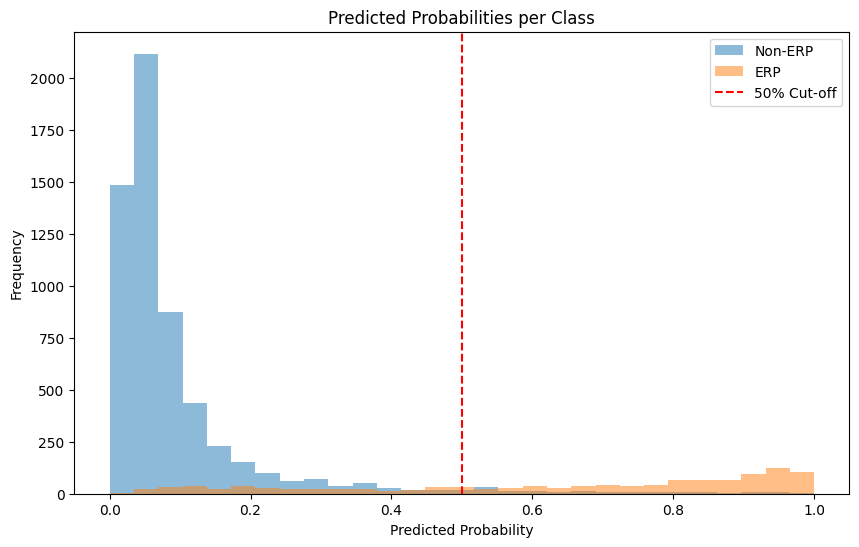

In [15]:
probabilities = np.array(y_pred)
actual_labels = np.array(y_true)

# Separate the probabilities based on the actual class labels
class_0_probs = probabilities[actual_labels == 0]
class_1_probs = probabilities[actual_labels == 1]

# Create histograms
plt.figure(figsize=(10, 6))

# Plot histogram for class 0
plt.hist(class_0_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='Non-ERP')

# Plot histogram for class 1
plt.hist(class_1_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='ERP')

# Add vertical line at 0.5 (50% cut-off)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Cut-off')

plt.title('Predicted Probabilities per Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right') 

# Show the plot
plt.show()

In [17]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = np.round(y_pred)
print(y_true.shape, y_pred.shape)
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(confusion_matrix(y_true, y_pred))

(7000,) (7000,)
Accuracy: 0.9287142857142857
F1: 0.7649552520018842
[[5689  143]
 [ 356  812]]
